<a href="https://colab.research.google.com/github/jameszlj/NLP_with_python/blob/master/fast_ai_text_two_class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from fastai.text import *

In [2]:
!wget https://github.com/wshuyi/public_datasets/raw/master/dianping.csv

--2019-10-12 09:00:06--  https://github.com/wshuyi/public_datasets/raw/master/dianping.csv
Resolving github.com (github.com)... 140.82.118.3
Connecting to github.com (github.com)|140.82.118.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/wshuyi/public_datasets/master/dianping.csv [following]
--2019-10-12 09:00:06--  https://raw.githubusercontent.com/wshuyi/public_datasets/master/dianping.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 531037 (519K) [text/plain]
Saving to: ‘dianping.csv’

dianping.csv        100%[===================>] 518.59K  --.-KB/s    in 0.03s   

2019-10-12 09:00:07 (17.9 MB/s) - ‘dianping.csv’ saved [531037/531037]



In [0]:
df = pd.read_csv("dianping.csv")

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
train, test = train_test_split(df, test_size=.2, random_state=2)

In [0]:
train, valid = train_test_split(train, test_size=.2, random_state=2)

In [0]:
len(train)

1280

In [0]:
len(valid)

320

In [0]:
len(test)

400

In [7]:
train.head()

,comment,sentiment
330,跟老公去大悦城玩儿的时候吃的，味道真的还不错哦！这家店是一对年轻的小两口自主创业开的店，环境...,1
1326,味道是好，但是真的很生气，排了两个小时的队伍就为了吃干酪鱼，进来被告知没有了，我觉得起码没有...,0
666,还好吧，调调不错，排队人多。。,1
1753,星期一人依旧是那么多，五点刚过就到了，基本上坐满了。菜品种类不少，这次赶上了青口贝挺好的。烤...,1
1885,4点半进去没等座。大拉皮好实惠。麻酱别都放否则太甜。薰骨肉香味浓。家常茄子精工细做，很好。还...,1


In [8]:
!pip install pytorch-transformers

     |████████████████████████████████| 184kB 6.3MB/s 
     |████████████████████████████████| 860kB 41.7MB/s 
     |████████████████████████████████| 655kB 37.3MB/s 
     |████████████████████████████████| 1.0MB 31.6MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.35-cp36-none-any.whl size=883999 sha256=81801ec66268c04d46c4240577be546b55a511cadd87a349e4bb15f823303931
  Stored in directory: /root/.cache/pip/wheels/63/2a/db/63e2909042c634ef551d0d9ac825b2b0b32dede4a6d87ddc94
  Created wheel for regex: filename=regex-2019.8.19-cp36-cp36m-linux_x86_64.whl size=609235 sha256=19961e21c40f20aa04ae082c7a9e3db7d6fc5a023b594f9790ee9efffa019d44
  Stored in directory: /root/.cache/pip/wheels/90/04/07/b5010fb816721eb3d6dd64ed5cc8111ca23f97fdab8619b5be
Successfully built sacremoses regex


In [0]:
from pytorch_transformers import BertTokenizer, BertForSequenceClassification

In [0]:
bert_model = "bert-base-chinese"
max_seq_len = 128
batch_size = 32

In [11]:
bert_tokenizer = BertTokenizer.from_pretrained(bert_model)

100%|██████████| 109540/109540 [00:00<00:00, 650490.53B/s]


In [12]:
list(bert_tokenizer.vocab.items())[2000:2005]

[('姗', 2000), ('姚', 2001), ('姜', 2002), ('姝', 2003), ('姣', 2004)]

In [0]:
bert_vocab = Vocab(list(bert_tokenizer.vocab.keys()))

In [0]:
class BertFastaiTokenizer(BaseTokenizer):
    def __init__(self, tokenizer, max_seq_len=128, **kwargs):
        self.pretrained_tokenizer = tokenizer
        self.max_seq_len = max_seq_len

    def __call__(self, *args, **kwargs):
        return self

    def tokenizer(self, t):
        return ["[CLS]"] + self.pretrained_tokenizer.tokenize(t)[:self.max_seq_len - 2] + ["[SEP]"]

In [0]:
tok_func = BertFastaiTokenizer(bert_tokenizer, max_seq_len=max_seq_len)

In [0]:
bert_fastai_tokenizer = Tokenizer(
    tok_func=tok_func,
    pre_rules = [],
    post_rules = []
)

In [0]:
path = Path(".")

In [0]:
databunch = TextClasDataBunch.from_df(path, train, valid, test,
                  tokenizer=bert_fastai_tokenizer,
                  vocab=bert_vocab,
                  include_bos=False,
                  include_eos=False,
                  text_cols="comment",
                  label_cols='sentiment',
                  bs=batch_size,
                  collate_fn=partial(pad_collate, pad_first=False, pad_idx=0),
             )

In [20]:
databunch.show_batch()

text,target
[CLS] 第 一 次 去 吃 是 国 庆 期 间 ， 吃 五 十 返 五 十 ！ 说 实 话 确 实 有 些 菜 不 错 ！ 拿 着 返 券 第 二 次 再 去 的 时 候 ！ 略 有 失 望 ！ 妈 妈 熏 排 骨 第 二 次 点 的 大 份 ， 比 第 一 次 第 一 次 点 的,1
[CLS] 早 就 听 说 过 他 家 不 错 ， 但 是 由 于 听 闻 一 直 太 火 爆 ， 导 致 一 直 没 有 去 拔 草 。 上 星 期 终 于 吃 到 啦 ， 工 作 日 的 中 午 去 的 ， 11 点 多 那 时 候 已 经 人 头 攒 动 了 。 先 说 配 餐 ，,1
[CLS] 实 在 不 理 解 为 什 么 点 评 这 么 火 ， 外 边 还 有 好 多 人 排 队 。 这 个 菜 的 口 味 放 北 京 也 许 是 正 常 的 ， 但 是 在 天 津 这 种 风 味 水 平 根 本 不 值 得 尝 试 ， 更 别 提 排 队 了 。 随 便 找,0
[CLS] 如 果 能 打 负 分 的 话 一 定 给 他 打 负 分 ， 可 惜 没 有 ！ 跟 朋 友 聚 会 去 的 这 家 自 助 、 大 周 五 的 差 不 多 8 点 应 该 也 不 是 很 晚 吧 ， 几 个 人 进 去 后 东 西 都 没 有 什 么 了 ， 服 务 员,0
[CLS] 先 团 的 券 ， 进 去 后 就 不 想 吃 了 ， 把 券 退 了 ， 因 为 同 伴 拿 了 一 杯 水 回 来 ， 服 务 员 告 知 必 须 交 钱 了 ， 那 就 在 这 吃 吧 。 结 果 交 的 现 金 。 客 观 的 说 ， 东 西 种 类 是 不 少 ，,0


In [0]:
class MyNoTupleModel(BertForSequenceClassification):
  def forward(self, *args, **kwargs):
    return super().forward(*args, **kwargs)[0]

In [22]:
bert_pretrained_model = MyNoTupleModel.from_pretrained(bert_model, num_labels=2)

100%|██████████| 411577189/411577189 [00:13<00:00, 29549860.83B/s]


In [0]:
loss_func = nn.CrossEntropyLoss()

In [0]:
learn = Learner(databunch, 
                bert_pretrained_model,
                loss_func=loss_func,
                metrics=accuracy)

In [0]:
torch.cuda.set_device(0)

In [25]:
if torch.cuda.is_available():
    print(bert_pretrained_model.cuda())
    print("Check Done")

MyNoTupleModel(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(21128, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tru

In [26]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


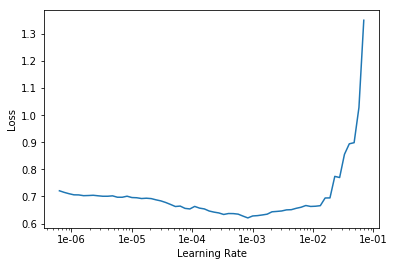

In [27]:
learn.recorder.plot()

In [28]:
learn.fit_one_cycle(2, 2e-5)

epoch,train_loss,valid_loss,accuracy,time
0,0.554093,0.363615,0.859375,00:36
1,0.379899,0.286867,0.875000,00:36


In [0]:
def dumb_series_prediction(n):
  preds = []
  for loc in range(n):
    preds.append(int(learn.predict(test.iloc[loc]['comment'])[1]))
  return preds

In [0]:
preds = dumb_series_prediction(len(test))

In [31]:
preds[:10]

[1, 1, 1, 1, 1, 0, 1, 1, 0, 1]

In [0]:
from sklearn.metrics import classification_report, confusion_matrix

In [33]:
print(classification_report(test.sentiment, preds))

              precision    recall  f1-score   support

           0       0.89      0.88      0.88       203
           1       0.88      0.88      0.88       197

    accuracy                           0.88       400
   macro avg       0.88      0.88      0.88       400
weighted avg       0.88      0.88      0.88       400



In [34]:
print(confusion_matrix(test.sentiment, preds))

[[179  24]
 [ 23 174]]
